In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
from typing import List, Tuple
from PIL import Image

In [2]:

def load_images_from_directory(directory): # Load image files from a directory
    
    image_files = []
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith(".jpg"):
                image_files.append(os.path.join(root, filename))
    return image_files

def load_dataset(dataset_dir): # Load image and annotation pairs from a dataset directory

    train_images = load_images_from_directory(os.path.join(dataset_dir, "train", "JPEGImages"))
    test_images = load_images_from_directory(os.path.join(dataset_dir, "test", "JPEGImages"))

    # Map each image to its corresponding annotation
    train_annotations = [image.replace("JPEGImages", "Annotations").replace(".jpg", ".xml") for image in train_images]
    test_annotations = [image.replace("JPEGImages", "Annotations").replace(".jpg", ".xml") for image in test_images]

    return train_images, train_annotations, test_images, test_annotations


In [3]:
dataset_dir = "data1/VOC2012"  
train_images, train_annotations, test_images, test_annotations = load_dataset(dataset_dir)

In [4]:
def process_annotation(xml_root: ET.Element) -> Tuple[List[Tuple[int, int, int, int]], List[str]]: #Process annotation data from an XML root element

    bounding_boxes = []
    labels = []

    for object_elem in xml_root.findall("object"):
        bndbox = object_elem.find("bndbox")
        x_min = int(bndbox.find("xmin").text)
        y_min = int(bndbox.find("ymin").text)
        x_max = int(bndbox.find("xmax").text)
        y_max = int(bndbox.find("ymax").text)

        label = object_elem.find("name").text
        bounding_boxes.append((x_min, y_min, x_max, y_max))
        labels.append(label)

    return bounding_boxes, labels

#     Load images and annotations from a list of image paths and annotation paths.
def load_images_and_annotations(image_paths: List[str], annotation_paths: List[str]) -> Tuple[List[Image.Image], List[List[Tuple[int, int, int, int]]], List[List[str]]]:
    
    images = []
    bounding_boxes = []
    labels = []

    for image_path, annotation_path in zip(image_paths, annotation_paths):
        image = Image.open(image_path)
        xml_root = ET.parse(annotation_path).getroot()
        bndboxes, lbls = process_annotation(xml_root)
        images.append(image)
        bounding_boxes.append(bndboxes)
        labels.append(lbls)

    return images, bounding_boxes, labels   

In [5]:
train_images, train_bounding_boxes, train_labels = load_images_and_annotations(train_images, train_annotations)
test_images, test_bounding_boxes, test_labels = load_images_and_annotations(test_images, test_annotations)

In [6]:
flat_train_labels = [label for sublist in train_labels for label in sublist]
flat_test_labels = [label for sublist in test_labels for label in sublist]

## Statistics

In [7]:
from tabulate import tabulate
from collections import Counter

def generate_label_statistics(train_labels, test_labels):
    all_labels = train_labels + test_labels

    # Calculate the number of occurrences of each class in the combined labels
    class_counts = Counter(all_labels)
    
    # Get a list of unique labels
    unique_labels = sorted(list(set(all_labels)))

    # Prepare the data for tabulation
    table_data = []

    for label in unique_labels:
        train_count = train_labels.count(label)
        test_count = test_labels.count(label)
        total_count = class_counts[label]

        train_percent = (train_count / total_count) * 100
        test_percent = (test_count / total_count) * 100

        table_data.append([label, total_count, train_count, f"{train_percent:.2f}%", test_count, f"{test_percent:.2f}%"])

    # Calculate the total number of images in the train and test sets
    total_train_images = len(train_labels)
    total_test_images = len(test_labels)
    total_images = total_train_images + total_test_images

    # Append a row with totals
    table_data.append(["TOTAL", total_images, total_train_images, "100.00%", total_test_images, "100.00%"])

    # Print the table
    headers = ["Label", "Images", "Train imgs", "Train(%)", "Test imgs", "Test(%)"]
    print(tabulate(table_data, headers, tablefmt="grid"))

# Use your loaded labels to generate statistics
generate_label_statistics(flat_train_labels,flat_test_labels)


+----------------------+----------+--------------+------------+-------------+-----------+
| Label                |   Images |   Train imgs | Train(%)   |   Test imgs | Test(%)   |
+======================+==========+==============+============+=============+===========+
| agriculture forestry |      389 |          247 | 63.50%     |         142 | 36.50%    |
+----------------------+----------+--------------+------------+-------------+-----------+
| construction waste   |      707 |          581 | 82.18%     |         126 | 17.82%    |
+----------------------+----------+--------------+------------+-------------+-----------+
| disposed garbage     |       12 |            9 | 75.00%     |           3 | 25.00%    |
+----------------------+----------+--------------+------------+-------------+-----------+
| domestic garbage     |     2936 |         2301 | 78.37%     |         635 | 21.63%    |
+----------------------+----------+--------------+------------+-------------+-----------+
| industry

/tmp/ipykernel_11897/1247706335.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts, y=class_names, palette="viridis")


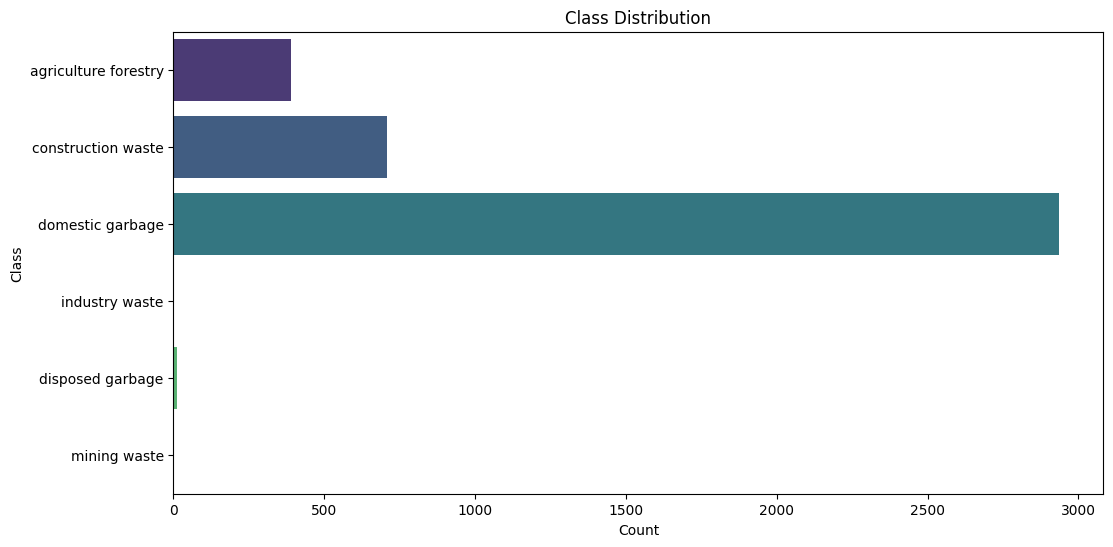

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(train_labels, test_labels):
    all_labels = train_labels + test_labels

    # Calculate the number of occurrences of each class in the combined labels
    class_counts = Counter(all_labels)

    # Get a list of unique labels
    unique_labels = sorted(list(set(all_labels)))

    # Prepare the data for plotting
    class_names = [label for label, count in class_counts.items()]
    class_counts = [count for label, count in class_counts.items()]

    # Plot the class distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_counts, y=class_names, palette="viridis")
    plt.title("Class Distribution")
    plt.xlabel("Count")
    plt.ylabel("Class")
    plt.show()

# Use your loaded labels to plot the class distribution
plot_class_distribution(flat_train_labels, flat_test_labels)

# Quick Remark here. 

Since this dataset contains waste so I decided to combine them all labels them as "dumpsite" and use the data set that we have in AerialWaste that are not illegal as a class which will be call "no dumpsite". The cell below shows the process.

In [9]:
def rename_labels_to_dumpsite(labels): #Rename all labels in a list to "dumpsite
   
    return ["dumpsite" for _ in labels]

train_labels = rename_labels_to_dumpsite(train_labels)
test_labels = rename_labels_to_dumpsite(test_labels)

In [10]:
# check the statistics again
generate_label_statistics(train_labels, test_labels)

+----------+----------+--------------+------------+-------------+-----------+
| Label    |   Images |   Train imgs | Train(%)   |   Test imgs | Test(%)   |
+==========+==========+==============+============+=============+===========+
| dumpsite |     3395 |         2671 | 78.67%     |         724 | 21.33%    |
+----------+----------+--------------+------------+-------------+-----------+
| TOTAL    |     3395 |         2671 | 100.00%    |         724 | 100.00%   |
+----------+----------+--------------+------------+-------------+-----------+


# Quick note 

Here we combined both training and testing dataset together, so that when we get the dataset of the "no_dumpsite" we will merge the two dataset from both sources into a single directory structure, shuffle the combines data to ensure that the model doesn't see any pattern or order related to the source and decide on the percentage split between training and testing data for the combined shuffle dataset.

In [11]:
def rename_labels_to_dumpsite(labels): #  Renaming dumspites

    return [1 for _ in labels]

train_labels = rename_labels_to_dumpsite(train_labels)
test_labels = rename_labels_to_dumpsite(test_labels)

In [12]:
from PIL import Image
import os
import json

def save_images_as_coco_txt(images, bounding_boxes, labels, output_directory): # Combine the data, mark them as "dumpsites," and save them in COCO format as .txt files.
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    for i, (image, bboxes,label) in enumerate(zip(images, bounding_boxes,labels)):
        # Save image as JPEG
        image_filename = f"dumpsite_{i}.jpeg"
        image.save(os.path.join(output_directory, image_filename), "JPEG")
        
        # Create a .txt file for bounding box annotations
        txt_filename = f"dumpsite_{i}.txt"
        with open(os.path.join(output_directory, txt_filename), "w") as txt_file:
            for bbox in bboxes:
                xmin, ymin, xmax, ymax = bbox
                #print(label, xmin, ymin, xmax, ymax)
                txt_file.write(f"{label} {xmin} {ymin} {xmax} {ymax}\n")           

In [13]:
# Example usage
output_directory = "processed"

# Combine train and test data
combined_images = train_images + test_images

combined_bounding_boxes = train_bounding_boxes + test_bounding_boxes
combined_labels = train_labels + test_labels
# Save images as dumpsites
save_images_as_coco_txt(combined_images, combined_bounding_boxes, combined_labels, output_directory)

In [14]:
#shape of one image in the combined_images
combined_images[0].size

(1024, 1024)

# Quick note
We need the equivalent number of images in both training and test set so as to avoid imbalance labels in the classes 

In [1]:
from PIL import Image
import os
import json


def resize_image(image, new_size=(1024, 1024)):
    return image.resize(new_size, resample=Image.BILINEAR)

def save_images_as_yolo_no_dumpsite(data_dir, output_dir, output_txt_dir, max_images=3395):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create the output directory for YOLO annotation text files
    if not os.path.exists(output_txt_dir):
        os.makedirs(output_txt_dir)

    # Load the JSON data
    with open(os.path.join(data_dir, "training.json"), "r") as train_json_file:
        training_data = json.load(train_json_file)

    with open(os.path.join(data_dir, "testing.json"), "r") as test_json_file:
        testing_data = json.load(test_json_file)

    # Combine the data from both training and testing sets
    data = {
        "images": training_data["images"] + testing_data["images"],
        #"annotations": training_data["annotations"] + testing_data["annotations"],
    }

    # Filter images based on 'is_candidate_location' value
    filtered_images = [img for img in data["images"] if img.get("is_candidate_location") == 0]

    # Keep track of the number of saved images
    images_saved = 0

    # Process and save images
    for img_data in filtered_images:
        # Load and convert PNG images to JPEG
        img_path = os.path.join(data_dir, img_data["file_name"])
        img = Image.open(img_path)
        img = img.convert("RGB")
        img = resize_image(img, new_size=(1024, 1024))
        
        # Save as JPEG with a new name
        new_filename = f"no_dumpsite_{images_saved}.jpeg"
        new_img_path = os.path.join(output_dir, new_filename)
        img.save(new_img_path, "JPEG")

        # Create YOLO annotation file for the image
        annotation_filename = f"no_dumpsite_{images_saved}.txt"
        annotation_path = os.path.join(output_txt_dir, annotation_filename)
        with open(annotation_path, "w") as annotation_file:
            annotation_file.write(f"0 0 0 1024 1024\n")  # YOLO format: <class_id> <x_center> <y_center> <width> <height>

        # Update the count of saved images
        images_saved += 1

        # Stop after saving the specified number of images
        if images_saved >= max_images:
            break

    print(f"Saved {images_saved} images with the label 'no_dumpsite' in the '{output_dir}' directory.")
    print(f"Saved YOLO annotation files in '{output_txt_dir}' directory.")

In [2]:
data_dir = "data1/Aerial"
output_dir = "processed/images"

output_txt_dir = "processed/annotations/"
save_images_as_yolo_no_dumpsite(data_dir, output_dir, output_txt_dir)

Saved 3395 images with the label 'no_dumpsite' in the 'processed/images' directory.
Saved YOLO annotation files in 'processed/annotations/' directory.


## Save 100 dataset for testing 

In [2]:
from PIL import Image
import os
import json

def resize_image(image, new_size=(1024, 1024)):
    return image.resize(new_size, resample=Image.BILINEAR)

def save_testing_data(data_dir, output_dir, output_txt_dir, max_images=20):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create the output directory for YOLO annotation text files
    if not os.path.exists(output_txt_dir):
        os.makedirs(output_txt_dir)

    # Load the JSON data
    with open(os.path.join(data_dir, "testing_2.json"), "r") as test_json_file:
        testing_data = json.load(test_json_file)

    # Keep track of the number of saved images
    images_saved = 0

    # Process and save images with associated annotations
    for img_data, annotation_data in zip(testing_data["images"], testing_data["annotations"]):
        # Load and convert PNG images to JPEG
        img_path = os.path.join(data_dir, img_data["file_name"])
        img = Image.open(img_path)
        img = img.convert("RGB")
        img = resize_image(img, new_size=(1024, 1024))

        # Save as JPEG with a new name
        new_filename = f"{images_saved}.jpeg"
        new_img_path = os.path.join(output_dir, new_filename)
        img.save(new_img_path, "JPEG")

        # Extract bounding box information
        bbox = annotation_data["bbox"]
        xmin, ymin, xmax, ymax = bbox

        # Create YOLO annotation file for the image
        annotation_filename = f"{images_saved}.txt"
        annotation_path = os.path.join(output_txt_dir, annotation_filename)
        with open(annotation_path, "w") as annotation_file:
            annotation_file.write(f"1 {xmin} {ymin} {xmax} {ymax}\n")

        # Update the count of saved images
        images_saved += 1

        # Stop after saving the specified number of images
        if images_saved >= max_images:
            break


In [3]:
data_dir = "data1/Aerial"
output_dir = "processed/test/images"

output_txt_dir = "processed/test/annotations/"
save_testing_data(data_dir, output_dir, output_txt_dir)